# Parse mutation data for time series, frequency plots.

In [1]:
import numpy as np
import pandas as pd
import re
UA3_100 = pd.read_table('/Users/ymseah/Documents/sic_UA3-15_breseq/annotated.gd', comment='#', names=range(25))
UA3_100.insert(0, 'generation', 100)
UA3_100.insert(1, 'frequency', 0.0)
UA3_300 = pd.read_table('/Users/ymseah/Documents/sic_UA3.45_breseq/annotated.gd', comment='#', names=range(25))
UA3_300.insert(0, 'generation', 300)
UA3_300.insert(1, 'frequency', 0.0)
UA3_500 = pd.read_table('/Users/ymseah/Documents/sic_UA3-76_breseq/annotated.gd', comment='#', names=range(25))
UA3_500.insert(0, 'generation', 500)
UA3_500.insert(1, 'frequency', 0.0)
UA3_780 = pd.read_table('/Users/ymseah/Documents/sic_UA3.118_breseq/annotated.gd', comment='#', names=range(25))
UA3_780.insert(0, 'generation', 780)
UA3_780.insert(1, 'frequency', 0.0)
UA3_1000 = pd.read_table('/Users/ymseah/Documents/sic_UA3_S2_L001_breseq/output/evidence/annotated.gd', comment='#', names=range(25))
UA3_1000.insert(0, 'generation', 1000)
UA3_1000.insert(1, 'frequency', 0.0)

//anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [2]:
for row in UA3_100.itertuples():
    #check each column for polymorphism frequencies
    i = 6
    while i < 25:
        if re.match('frequency=', str(UA3_100.loc[row[0], i])):
            UA3_100.loc[row[0], 'frequency'] = re.sub('frequency=', '', str(UA3_100.loc[row[0], i]))
        i += 1
    if re.match('1|2|3|4|5|6|7|8|9', str(UA3_100.loc[row[0], 'frequency'])):
        UA3_100.loc[row[0], 'frequency'] = float(UA3_100.loc[row[0], 'frequency'])
    else:
        UA3_100.loc[row[0], 'frequency'] = 0.0
    #change position (col4) type to int for plotting
    UA3_100.loc[row[0], 4] = int(UA3_100.loc[row[0], 4])
UA3_100.rename(columns = {4:'position'}, inplace=True)

for row in UA3_300.itertuples():
    #check each column for polymorphism frequencies
    i = 6
    while i < 25:
        if re.match('frequency=', str(UA3_300.loc[row[0], i])):
            UA3_300.loc[row[0], 'frequency'] = re.sub('frequency=', '', str(UA3_300.loc[row[0], i]))
        i += 1
    if re.match('1|2|3|4|5|6|7|8|9', str(UA3_300.loc[row[0], 'frequency'])):
        UA3_300.loc[row[0], 'frequency'] = float(UA3_300.loc[row[0], 'frequency'])
    else:
        UA3_300.loc[row[0], 'frequency'] = 0.0
    #change position (col4) type to int for plotting
    UA3_300.loc[row[0], 4] = int(UA3_300.loc[row[0], 4])
UA3_300.rename(columns = {4:'position'}, inplace=True)

for row in UA3_500.itertuples():
    #check each column for polymorphism frequencies
    i = 6
    while i < 25:
        if re.match('frequency=', str(UA3_500.loc[row[0], i])):
            UA3_500.loc[row[0], 'frequency'] = re.sub('frequency=', '', str(UA3_500.loc[row[0], i]))
        i += 1
    if re.match('1|2|3|4|5|6|7|8|9', str(UA3_500.loc[row[0], 'frequency'])):
        UA3_500.loc[row[0], 'frequency'] = float(UA3_500.loc[row[0], 'frequency'])
    else:
        UA3_500.loc[row[0], 'frequency'] = 0.0
    #change position (col4) type to int for plotting
    UA3_500.loc[row[0], 4] = int(UA3_500.loc[row[0], 4])
UA3_500.rename(columns = {4:'position'}, inplace=True)

for row in UA3_780.itertuples():
    #check each column for polymorphism frequencies
    i = 6
    while i < 25:
        if re.match('frequency=', str(UA3_780.loc[row[0], i])):
            UA3_780.loc[row[0], 'frequency'] = re.sub('frequency=', '', str(UA3_780.loc[row[0], i]))
        i += 1
    if re.match('1|2|3|4|5|6|7|8|9', str(UA3_780.loc[row[0], 'frequency'])):
        UA3_780.loc[row[0], 'frequency'] = float(UA3_780.loc[row[0], 'frequency'])
    else:
        UA3_780.loc[row[0], 'frequency'] = 0.0
    #change position (col4) type to int for plotting
    UA3_780.loc[row[0], 4] = int(UA3_780.loc[row[0], 4])
UA3_780.rename(columns = {4:'position'}, inplace=True)

for row in UA3_1000.itertuples():
    #check each column for polymorphism frequencies
    i = 6
    while i < 25:
        if re.match('frequency=', str(UA3_1000.loc[row[0], i])):
            UA3_1000.loc[row[0], 'frequency'] = re.sub('frequency=', '', str(UA3_1000.loc[row[0], i]))
        i += 1
    if re.match('1|2|3|4|5|6|7|8|9', str(UA3_1000.loc[row[0], 'frequency'])):
        UA3_1000.loc[row[0], 'frequency'] = float(UA3_1000.loc[row[0], 'frequency'])
    else:
        UA3_1000.loc[row[0], 'frequency'] = 0.0
    #change position (col4) type to int for plotting
    UA3_1000.loc[row[0], 4] = int(UA3_1000.loc[row[0], 4])
UA3_1000.rename(columns = {4:'position'}, inplace=True)

In [4]:
UA3_df  = pd.concat([UA3_100, UA3_300, UA3_500, UA3_780, UA3_1000])
UA3_df.insert(0, 'line', 'UA3')
UA3_df

,line,generation,frequency,0,1,2,3,position,5,6,...,15,16,17,18,19,20,21,22,23,24
0,UA3,100,1,INS,1,109,NC_002937,42867,G,frequency=1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,UA3,100,1,INS,2,110,NC_002937,211389,A,frequency=1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,UA3,100,1,MOB,3,"1494,1495",NC_002937,629936,ISD1,-1,...,repeat_size=1200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,UA3,100,1,SNP,4,112,NC_002937,716874,A,frequency=1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,UA3,100,1,DEL,5,113,NC_002937,882512,1,frequency=1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,UA3,100,1,INS,6,116,NC_002937,1313341,C,frequency=1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,UA3,100,1,SNP,7,117,NC_002937,1426830,G,aa_new_seq=G,...,gene_name=DVU1349,gene_position=122,gene_product=geranylgeranyl diphosphate synthase,gene_strand=>,html_gene_name=<i>DVU1349</i>&nbsp;&rarr;,locus_tag=DVU1349,snp_type=nonsynonymous,transl_table=11,NaN,NaN
7,UA3,100,1,SNP,8,118,NC_002937,1773256,C,aa_new_seq=E,...,gene_name=DVU1698,gene_position=316,gene_product=hypothetical protein,gene_strand=<,html_gene_name=<i>DVU1698</i>&nbsp;&larr;,locus_tag=DVU1698,snp_type=nonsynonymous,transl_table=11,NaN,NaN
8,UA3,100,1,DEL,9,119,NC_002937,1773345,1,frequency=1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,UA3,100,1,SNP,10,120,NC_002937,1913197,G,aa_new_seq=L,...,gene_name=DVU1842,gene_position=304,gene_product=lipoprotein,gene_strand=<,html_gene_name=<i>DVU1842</i>&nbsp;&larr;,locus_tag=DVU1842,snp_type=nonsynonymous,transl_table=11,NaN,NaN


In [12]:
DvH_UA3 = UA3_df[UA3_df[3] == 'NC_002937']
DvH_UA3_nonzero = DvH_UA3[DvH_UA3['frequency'] > 0]
DvHplasmid_UA3 = UA3_df[UA3_df[3] == 'NC_005863']
DvHplasmid_UA3_nonzero = DvHplasmid_UA3[DvHplasmid_UA3['frequency'] > 0]
MmS2_UA3 = UA3_df[UA3_df[3] == 'NC_005791']
MmS2_UA3_nonzero = MmS2_UA3[MmS2_UA3['frequency'] > 0]

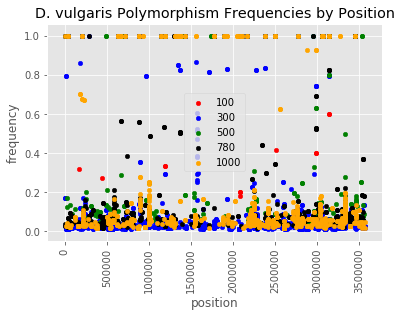

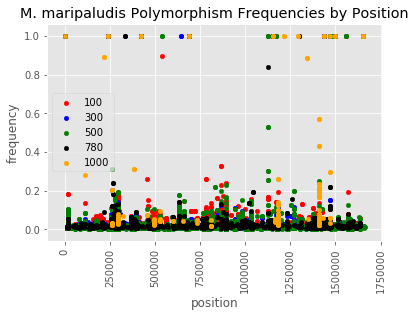

In [51]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

DvH_UA3_gen = DvH_UA3_nonzero.groupby('generation')
DvHplasmid_UA3_gen = DvHplasmid_UA3_nonzero.groupby('generation')
MmS2_UA3_gen = MmS2_UA3_nonzero.groupby('generation')
colors = {100: 'red', 300: 'blue', 500: 'green', 780: 'black', 1000: 'orange'}

fig, ax = plt.subplots()
for generation, mut in DvH_UA3_gen:
    mut.plot.scatter(x = 'position', y = 'frequency', rot=90, ax = ax, label = generation, color = colors[generation])
    plt.title('D. vulgaris Polymorphism Frequencies by Position')
plt.show()

fig, ax = plt.subplots()
for generation, mut in MmS2_UA3_gen:
    mut.plot.scatter(x = 'position', y = 'frequency', rot=90, ax = ax, label = generation, color = colors[generation])
    plt.title('M. maripaludis Polymorphism Frequencies by Position')
plt.show()

## Problems & Solutions
### 1. Inconsistent number of columns in gdiff output files raises error with pandas read_table() function.
Solution 1: Table headers need to be specified with read_table(names=[]) to assign NaN to "missing" column values.

Solution 2: Use index.html output instead, parse into data structure acceptable by pandas.

In [263]:
#This is Solution 2
import re
from bs4 import BeautifulSoup
soup = BeautifulSoup(open('/Users/ymseah/Documents/sic_UA3_S2_L001_breseq/output/index.html'), 'html5lib')

#EXAMPLE ROW
#<tr class="normal_table_row">
#<td align="center"><a href="evidence/INS_1.html">RA</a></td><!-- Evidence -->
#<td align="center">NC_002937</td><!-- Seq_Id -->
#<td align="right">42,867</td><!-- Position -->
#<td align="center">+G</td><!-- Cell Mutation -->
#<td align="right">100%</td>
#<td align="center">intergenic (‑125/+57)</td>
#<td align="center"><i>DVU0036</i> ← / ← <i>DVU0037</i></td>
#<td align="left">hypothetical protein/hypothetical protein</td>
#</tr>

#get each consensus mode row 
tr_consensus = soup('tr', 'normal_table_row')
cons_ref_genome = [tr.find_all_next('td')[1].text for tr in tr_consensus]
cons_mutation_pos = [tr.find_all_next('td')[2].text for tr in tr_consensus]
cons_mutation = [tr.find_all_next('td')[3].text for tr in tr_consensus]
cons_freq = [tr.find_all_next('td')[4].text for tr in tr_consensus]

#get each polymorphism mode row
tr_polymorphism = soup('tr', 'polymorphism_table_row')
polym_ref_genome = [tr.find_all_next('td')[1].text for tr in tr_polymorphism]
polym_mutation_pos = [tr.find_all_next('td')[2].text for tr in tr_polymorphism]
polym_mutation = [tr.find_all_next('td')[3].text for tr in tr_polymorphism]
polym_freq = [tr.find_all_next('td')[4].text for tr in tr_polymorphism]

ref_genome = cons_ref_genome + polym_ref_genome

mutation_pos = cons_mutation_pos + polym_mutation_pos
clean_mutation_pos = []
i = 0
while i < len(mutation_pos):
    clean_position = re.sub(',', '', mutation_pos[i])
    clean_mutation_pos.append(int(clean_position))
    i += 1

freq = cons_freq + polym_freq
clean_freqs = []
i = 0
while i < len(freq):
    clean_freq = re.sub('%', '', freq[i])
    clean_freqs.append(float(clean_freq))
    i += 1

mutation_freq_dict = {'genome': ref_genome, 'position': clean_mutation_pos, 'frequency': clean_freqs}

In [264]:
import numpy as np
import pandas as pd
df = pd.DataFrame(mutation_freq_dict)
DvH = df.loc[df['genome'] == 'NC_002937']
#DvHplasmid = df.loc[df['genome'] == 'NC_005863']
MmS2 = df.loc[df['genome'] == 'NC_005791']

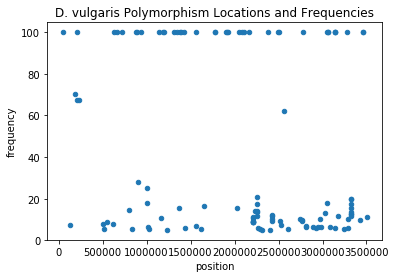

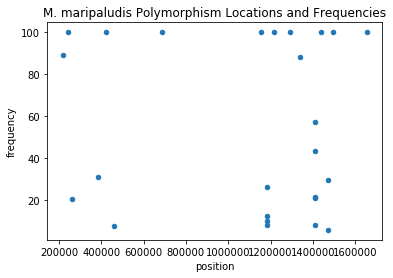

In [265]:
import matplotlib.pyplot as plt
DvH.plot.scatter(x = 'position', y = 'frequency')
plt.title('D. vulgaris Polymorphism Locations and Frequencies')
plt.show()
MmS2.plot.scatter(x = 'position', y = 'frequency')
plt.title('M. maripaludis Polymorphism Locations and Frequencies')
plt.show()